# Estimate non-CO2, non-CH4, non-N2O forcing

- Done as function of CO2 FFI emissions, can be done total CO2 if needed
- Include solar and volcanic for history

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import scipy.stats as st
from scipy.signal import savgol_filter
from matplotlib.lines import Line2D
from tqdm.auto import tqdm

/nfs/b0110/Users/mencsm/miniconda3/envs/frida-forcing/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ar6_df = pd.read_csv('../data/ar6_wg3_scenarios.csv')

In [3]:
ar6_df.Variable.unique()

array(['AR6 climate diagnostics|Effective Radiative Forcing|Basket|Anthropogenic non-CO2-CH4-N2O|FaIRv1.6.2|50.0th Percentile',
       'AR6 climate diagnostics|Effective Radiative Forcing|Basket|Anthropogenic|FaIRv1.6.2|50.0th Percentile',
       'AR6 climate diagnostics|Effective Radiative Forcing|CH4|FaIRv1.6.2|50.0th Percentile',
       'AR6 climate diagnostics|Effective Radiative Forcing|CO2|FaIRv1.6.2|50.0th Percentile',
       'AR6 climate diagnostics|Effective Radiative Forcing|FaIRv1.6.2|50.0th Percentile',
       'AR6 climate diagnostics|Effective Radiative Forcing|N2O|FaIRv1.6.2|50.0th Percentile',
       'AR6 climate diagnostics|Harmonized|Emissions|CO2|Energy and Industrial Processes'],
      dtype=object)

In [4]:
ar6_df

,Model,Scenario,Region,Variable,Unit,1995,1996,1997,1998,1999,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,AIM/CGE 2.0,SSP1-26,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,-0.467004,-0.448406,-0.535296,-0.526900,-0.417052,...,-0.061078,-0.060085,-0.058833,-0.057758,-0.056750,-0.055840,-0.054865,-0.054404,-0.053677,-0.051982
1,AIM/CGE 2.0,SSP1-26,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,1.636460,1.684510,1.627874,1.671092,1.815591,...,2.981693,2.976049,2.970522,2.964628,2.959076,2.953401,2.948116,2.942070,2.936613,2.931564
2,AIM/CGE 2.0,SSP1-26,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,0.503463,0.504183,0.505825,0.509215,0.512248,...,0.167832,0.166360,0.164919,0.163506,0.162117,0.160750,0.159403,0.158074,0.156761,0.155461
3,AIM/CGE 2.0,SSP1-26,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,1.471549,1.496910,1.522611,1.551692,1.580700,...,2.585070,2.579409,2.573590,2.567569,2.561949,2.556296,2.550965,2.545383,2.540125,2.534307
4,AIM/CGE 2.0,SSP1-26,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,1.726261,1.829280,1.810633,1.908043,2.083303,...,3.015661,3.036785,3.019582,2.991755,2.968416,2.942514,2.931088,2.919937,2.924517,2.940808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8409,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,0.503463,0.504183,0.505825,0.509215,0.512248,...,0.641046,0.639387,0.637588,0.635664,0.633625,0.631484,0.629250,0.626931,0.624535,0.622070
8410,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,1.471549,1.496910,1.522611,1.551692,1.580700,...,6.072179,6.128475,6.184595,6.240336,6.295445,6.348240,6.401096,6.453596,6.505259,6.556166
8411,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,1.726261,1.829280,1.810633,1.908043,2.083303,...,7.221970,7.308284,7.354097,7.388602,7.424990,7.449062,7.497821,7.548879,7.604435,7.694667
8412,WITCH-GLOBIOM 4.4,CD-LINKS_NoPolicy,World,AR6 climate diagnostics|Effective Radiative Fo...,W/m^2,0.128452,0.131823,0.134733,0.137085,0.139695,...,0.366853,0.368540,0.370207,0.371835,0.373453,0.375060,0.376664,0.378249,0.379797,0.381309


In [5]:
ar6_df.loc[ar6_df['Variable']=='AR6 climate diagnostics|Harmonized|Emissions|CO2|Energy and Industrial Processes']

,Model,Scenario,Region,Variable,Unit,1995,1996,1997,1998,1999,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
6,AIM/CGE 2.0,SSP1-26,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,3409.149300,3350.646300,3292.143300,3233.640300,3175.137300,3116.634300,3058.131300,2999.628300,2941.125300,2882.622300
13,AIM/CGE 2.0,SSP1-34,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,12498.218090,12326.808780,12155.399470,11983.990160,11812.580850,11641.171540,11469.762230,11298.352920,11126.943610,10955.534300
20,AIM/CGE 2.0,SSP1-45,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,22743.401480,22497.073560,22250.745640,22004.417720,21758.089800,21511.761880,21265.433960,21019.106040,20772.778120,20526.450200
27,AIM/CGE 2.0,SSP1-Baseline,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,31874.935510,31733.715720,31592.495930,31451.276140,31310.056350,31168.836560,31027.616770,30886.396980,30745.177190,30603.957400
34,AIM/CGE 2.0,SSP4-26,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,37.589260,-70.926980,-179.443220,-287.959460,-396.475700,-504.991940,-613.508180,-722.024420,-830.540660,-939.056900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8385,WITCH-GLOBIOM 4.4,CD-LINKS_NPi,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,82446.903068,82112.396945,81777.890823,81443.384700,81108.878577,80774.372454,80439.866331,80105.360209,79770.854086,79436.347963
8392,WITCH-GLOBIOM 4.4,CD-LINKS_NPi2020_1000,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,-1717.026445,-1955.642336,-2194.258226,-2432.874116,-2671.490007,-2910.105897,-3148.721788,-3387.337678,-3625.953569,-3864.569459
8399,WITCH-GLOBIOM 4.4,CD-LINKS_NPi2020_1600,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,5206.176112,4879.809222,4553.442333,4227.075444,3900.708555,3574.341665,3247.974776,2921.607887,2595.240997,2268.874108
8406,WITCH-GLOBIOM 4.4,CD-LINKS_NPi2020_400,World,AR6 climate diagnostics|Harmonized|Emissions|C...,Mt CO2/yr,NaN,NaN,NaN,NaN,NaN,...,-10427.671996,-10357.783908,-10287.895820,-10218.007733,-10148.119645,-10078.231557,-10008.343469,-9938.455381,-9868.567293,-9798.679205


 85%|██████████████████████████████████████████▍       | 73/86 [00:00<00:00, 375.88it/s]

2020 -0.0020089422339796127 -0.15298413765008062
2030 -0.006719891855509117 0.11859878992501499
2040 -0.0017183551473319205 0.00012265304343068995
2050 0.0009521899482813695 -0.04921882137505404
2060 0.0020922911172572677 -0.05125258187724846
2070 0.0025857332800268483 -0.0342263649532069
2080 0.0028692509172115977 -0.01237805918802378
2090 0.0029810901280550484 0.012792092086086962


100%|██████████████████████████████████████████████████| 86/86 [00:00<00:00, 361.51it/s]

2100 0.0034996369548795023 0.035218620167458414


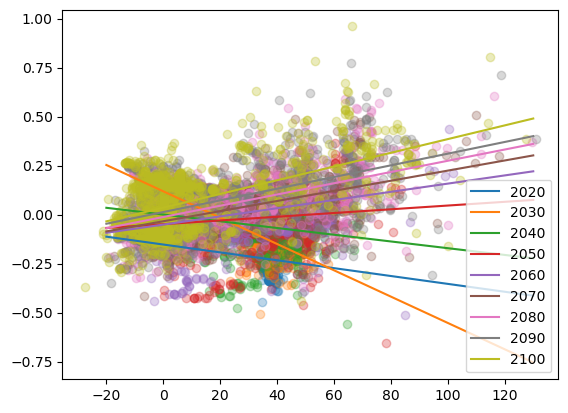

In [ ]:
y = np.empty((0))
#x = np.empty((0, 3))
x = np.empty((0, 2))

fig, ax = pl.subplots()
for year in tqdm(range(2015, 2101)):
    ffi = 0.001*ar6_df.loc[ar6_df['Variable']=='AR6 climate diagnostics|Harmonized|Emissions|CO2|Energy and Industrial Processes', str(year)]
    erf = ar6_df.loc[ar6_df['Variable']=='AR6 climate diagnostics|Effective Radiative Forcing|Basket|Anthropogenic non-CO2-CH4-N2O|FaIRv1.6.2|50.0th Percentile', str(year)]
    time = np.ones(1202) * year
    time2 = np.ones(1202) * year * year
    y = np.append(y, erf)
    #x = np.append(x, np.column_stack([ffi, time, time2]), axis=0)
    x = np.append(x, np.column_stack([ffi, time]), axis=0)
    if year%10==0:
        sl, ic, _, _, _ = st.linregress(ffi, erf)
        shade = (2120-year)/100
        ax.scatter(ffi, erf, alpha=0.3)
        print(year, sl, ic)
        ax.plot(np.linspace(-20, 130), np.linspace(-20, 130) * sl + ic, label=year)
ax.legend()

In [7]:
#sm_df = pd.DataFrame(x, columns=['ffi', 'year', 'year2'])
sm_df = pd.DataFrame(x, columns=['ffi', 'year'])
sm_df['erf'] = y# - 3.21
#results = ols(formula = "erf ~ ffi + year + year2", data=sm_df).fit()
results = ols(formula = "erf ~ ffi + year", data=sm_df).fit()

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    erf   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                 3.108e+04
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:30:10   Log-Likelihood:                 77154.
No. Observations:              103372   AIC:                        -1.543e+05
Df Residuals:                  103369   BIC:                        -1.543e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.1749      0.033   -250.324      0.000      -8.239      -8.111
ffi            0.0021   1.93e-05    110.504      0.000       0.002       0.002
year           0.0039   1.58e-05    249.177      0.000       0.004       0.004
==============================================================================
Omnibus:                     1443.690   Durbin-Watson:                   0.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2474.042
Skew:                          -0.102   Prob(JB):                         0.00
Kurtosis:                       3.730   Cond. No.                     1.88e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
results.params

Intercept   -8.174912
ffi          0.002135
year         0.003933
dtype: float64

In [ ]:
pl.plot(
    np.arange(2015, 2101),
    (0.001 * ar6_df.loc[
        ar6_df['Variable']=='AR6 climate diagnostics|Harmonized|Emissions|CO2|Energy and Industrial Processes',
        '2015':'2100'
    ].values * results.params['ffi'] + 
    np.arange(2015, 2101)[:, None].T * results.params['year'] + 
#    np.arange(2015, 2101)[:, None].T**2 * results.params['year2'] +
    results.params['Intercept']).T
);

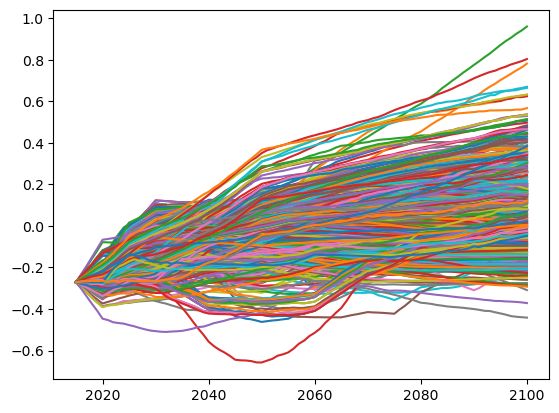

In [ ]:
pl.plot(
    np.arange(2015, 2101),
    ar6_df.loc[
        ar6_df['Variable']=='AR6 climate diagnostics|Effective Radiative Forcing|Basket|Anthropogenic non-CO2-CH4-N2O|FaIRv1.6.2|50.0th Percentile',
        '2015':'2100'
    ].values.T
);

In [ ]:
ar6_erf = pd.read_csv('../data/AR6_ERF_1750-2019.csv')

In [13]:
ar6_erf['total'] - ar6_erf['co2'] - ar6_erf['ch4'] - ar6_erf['n2o']

0      0.297568
1      0.284644
2      0.257959
3      0.218668
4      0.176235
         ...   
265   -0.126467
266   -0.116208
267   -0.077272
268   -0.085215
269   -0.070530
Length: 270, dtype: float64

In [14]:
transition = np.zeros(86)
transition[:10] = np.linspace(0.14, 0, 10)

(-2.5, 0.5)

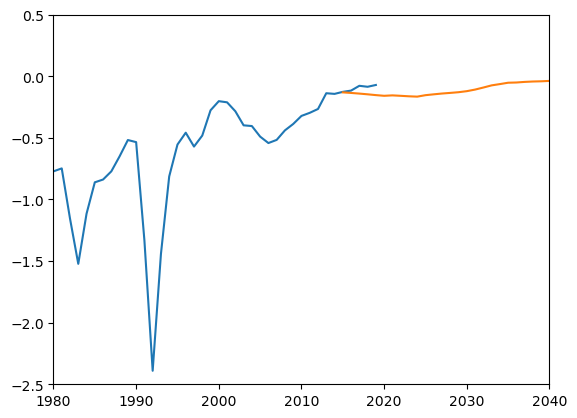

In [15]:
pl.plot(
    np.arange(1750, 2020),
    (ar6_erf['total'] - ar6_erf['co2'] - ar6_erf['ch4'] - ar6_erf['n2o']).values
)
pl.plot(
    np.arange(2015, 2101),
    np.median(
        ar6_df.loc[
            ar6_df['Variable']=='AR6 climate diagnostics|Effective Radiative Forcing|Basket|Anthropogenic non-CO2-CH4-N2O|FaIRv1.6.2|50.0th Percentile',
            '2015':'2100'
        ].values.T,
        axis=1
    ) + transition
)
pl.xlim(1980, 2040)
pl.ylim(-2.5, 0.5)

In [16]:
output = np.zeros((351))

output[:265] = (ar6_erf['total'] - ar6_erf['co2'] - ar6_erf['ch4'] - ar6_erf['n2o']).values[:265]

output[265:] = np.median(
    ar6_df.loc[
        ar6_df['Variable']=='AR6 climate diagnostics|Effective Radiative Forcing|Basket|Anthropogenic non-CO2-CH4-N2O|FaIRv1.6.2|50.0th Percentile',
        '2015':'2100'
    ].values.T,
    axis=1
) + transition

In [17]:
pd.DataFrame(output, index=np.arange(1750.5, 2101), columns=["residual_ERF"]).to_csv('../output/residual_ERF.csv')